
# Audio Feature Extractions

**Author**: [Moto Hira](moto@meta.com)_

``torchaudio`` implements feature extractions commonly used in the audio
domain. They are available in ``torchaudio.functional`` and
``torchaudio.transforms``.

``functional`` implements features as standalone functions.
They are stateless.

``transforms`` implements features as objects,
using implementations from ``functional`` and ``torch.nn.Module``.
They can be serialized using TorchScript.


In [1]:
import torch
import torchaudio
import torchaudio.functional as F
import torchaudio.transforms as T

print(torch.__version__)
print(torchaudio.__version__)

import librosa
import matplotlib.pyplot as plt

2.3.0+cu121
2.3.0+cu121


## Overview of audio features

The following diagram shows the relationship between common audio features
and torchaudio APIs to generate them.

<img src="https://download.pytorch.org/torchaudio/tutorial-assets/torchaudio_feature_extractions.png">

For the complete list of available features, please refer to the
documentation.




## Preparation

<div class="alert alert-info"><h4>Note</h4><p>When running this tutorial in Google Colab, install the required packages

   .. code::

      !pip install librosa</p></div>




In [2]:
from IPython.display import Audio
from matplotlib.patches import Rectangle
from torchaudio.utils import download_asset

torch.random.manual_seed(0)

SAMPLE_SPEECH = download_asset("tutorial-assets/Lab41-SRI-VOiCES-src-sp0307-ch127535-sg0042.wav")


def plot_waveform(waveform, sr, title="Waveform", ax=None):
    waveform = waveform.numpy()

    num_channels, num_frames = waveform.shape
    time_axis = torch.arange(0, num_frames) / sr

    if ax is None:
        _, ax = plt.subplots(num_channels, 1)
    ax.plot(time_axis, waveform[0], linewidth=1)
    ax.grid(True)
    ax.set_xlim([0, time_axis[-1]])
    ax.set_title(title)


def plot_spectrogram(specgram, title=None, ylabel="freq_bin", ax=None):
    if ax is None:
        _, ax = plt.subplots(1, 1)
    if title is not None:
        ax.set_title(title)
    ax.set_ylabel(ylabel)
    ax.imshow(librosa.power_to_db(specgram), origin="lower", aspect="auto", interpolation="nearest")


def plot_fbank(fbank, title=None):
    fig, axs = plt.subplots(1, 1)
    axs.set_title(title or "Filter bank")
    axs.imshow(fbank, aspect="auto")
    axs.set_ylabel("frequency bin")
    axs.set_xlabel("mel bin")

## Spectrogram

To get the frequency make-up of an audio signal as it varies with time,
you can use :py:func:`torchaudio.transforms.Spectrogram`.




In [3]:
# Load audio
SPEECH_WAVEFORM, SAMPLE_RATE = torchaudio.load(SAMPLE_SPEECH)

# Define transform
spectrogram = T.Spectrogram(n_fft=512)

# Perform transform
spec = spectrogram(SPEECH_WAVEFORM)

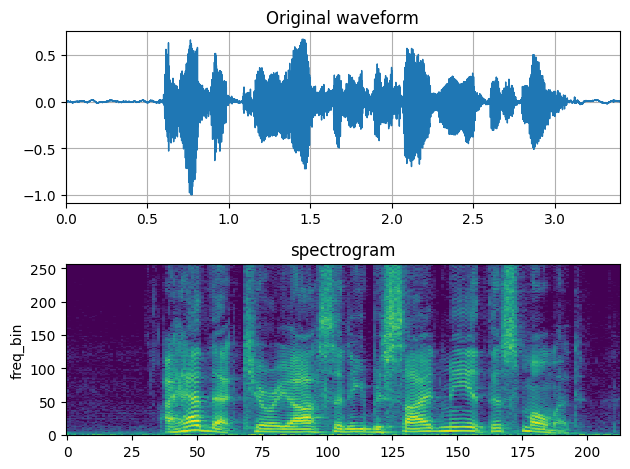

In [4]:
fig, axs = plt.subplots(2, 1)
plot_waveform(SPEECH_WAVEFORM, SAMPLE_RATE, title="Original waveform", ax=axs[0])
plot_spectrogram(spec[0], title="spectrogram", ax=axs[1])
fig.tight_layout()

In [5]:
Audio(SPEECH_WAVEFORM.numpy(), rate=SAMPLE_RATE)

### The effect of ``n_fft`` parameter

The core of spectrogram computation is (short-term) Fourier transform,
and the ``n_fft`` parameter corresponds to the $N$ in the following
definition of descrete Fourier transform.

$$ X_k = \\sum_{n=0}^{N-1} x_n e^{-\\frac{2\\pi i}{N} nk} $$

(For the detail of Fourier transform, please refer to
[Wikipedia](https://en.wikipedia.org/wiki/Fast_Fourier_transform)_.

The value of ``n_fft`` determines the resolution of frequency axis.
However, with the higher ``n_fft`` value, the energy will be distributed
among more bins, so when you visualize it, it might look more blurry,
even thought they are higher resolution.

The following illustrates this;




<div class="alert alert-info"><h4>Note</h4><p>``hop_length`` determines the time axis resolution.
   By default, (i.e. ``hop_length=None`` and ``win_length=None``),
   the value of ``n_fft // 4`` is used.
   Here we use the same ``hop_length`` value across different ``n_fft``
   so that they have the same number of elemets in the time axis.</p></div>




In [6]:
n_ffts = [32, 128, 512, 2048]
hop_length = 64

specs = []
for n_fft in n_ffts:
    spectrogram = T.Spectrogram(n_fft=n_fft, hop_length=hop_length)
    spec = spectrogram(SPEECH_WAVEFORM)
    specs.append(spec)

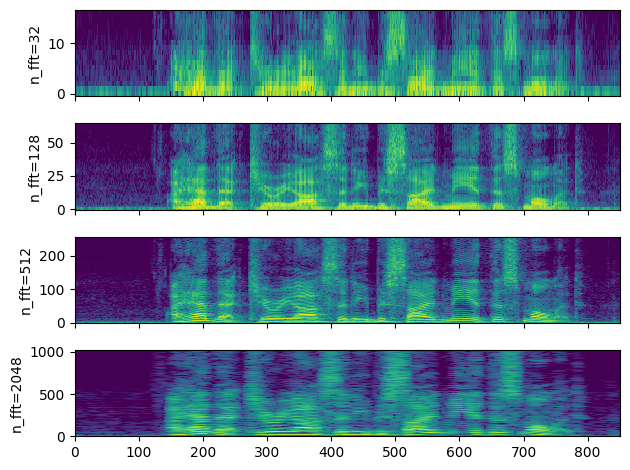

In [7]:
fig, axs = plt.subplots(len(specs), 1, sharex=True)
for i, (spec, n_fft) in enumerate(zip(specs, n_ffts)):
    plot_spectrogram(spec[0], ylabel=f"n_fft={n_fft}", ax=axs[i])
    axs[i].set_xlabel(None)
fig.tight_layout()

When comparing signals, it is desirable to use the same sampling rate,
however if you must use the different sampling rate, care must be
taken for interpretating the meaning of ``n_fft``.
Recall that ``n_fft`` determines the resolution of the frequency
axis for a given sampling rate. In other words, what each bin on
the frequency axis represents is subject to the sampling rate.

As we have seen above, changing the value of ``n_fft`` does not change
the coverage of frequency range for the same input signal.



Let's downsample the audio and apply spectrogram with the same ``n_fft``
value.



In [8]:
# Downsample to half of the original sample rate
speech2 = torchaudio.functional.resample(SPEECH_WAVEFORM, SAMPLE_RATE, SAMPLE_RATE // 2)
# Upsample to the original sample rate
speech3 = torchaudio.functional.resample(speech2, SAMPLE_RATE // 2, SAMPLE_RATE)

In [9]:
# Apply the same spectrogram
spectrogram = T.Spectrogram(n_fft=512)

spec0 = spectrogram(SPEECH_WAVEFORM)
spec2 = spectrogram(speech2)
spec3 = spectrogram(speech3)

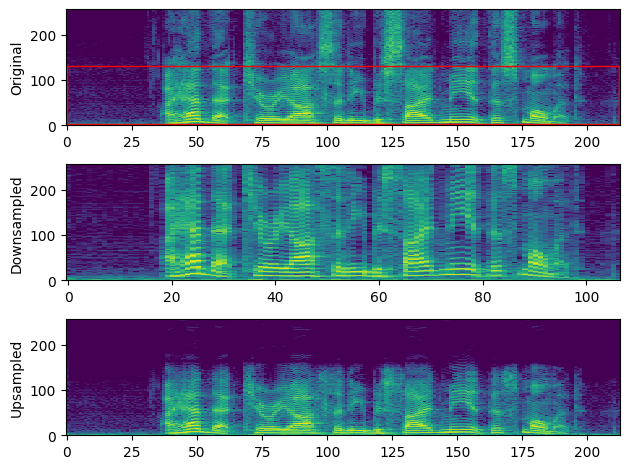

In [10]:
# Visualize it
fig, axs = plt.subplots(3, 1)
plot_spectrogram(spec0[0], ylabel="Original", ax=axs[0])
axs[0].add_patch(Rectangle((0, 3), 212, 128, edgecolor="r", facecolor="none"))
plot_spectrogram(spec2[0], ylabel="Downsampled", ax=axs[1])
plot_spectrogram(spec3[0], ylabel="Upsampled", ax=axs[2])
fig.tight_layout()

In the above visualization, the second plot ("Downsampled") might
give the impression that the spectrogram is streched.
This is because the meaning of frequency bins is different from
the original one.
Even though, they have the same number of bins, in the second plot,
the frequency is only covered to the half of the original sampling
rate.
This becomes more clear if we resample the downsampled signal again
so that it has the same sample rate as the original.



## GriffinLim

To recover a waveform from a spectrogram, you can use
:py:class:`torchaudio.transforms.GriffinLim`.

The same set of parameters used for spectrogram must be used.



In [11]:
# Define transforms
n_fft = 1024
spectrogram = T.Spectrogram(n_fft=n_fft)
griffin_lim = T.GriffinLim(n_fft=n_fft)

# Apply the transforms
spec = spectrogram(SPEECH_WAVEFORM)
reconstructed_waveform = griffin_lim(spec)

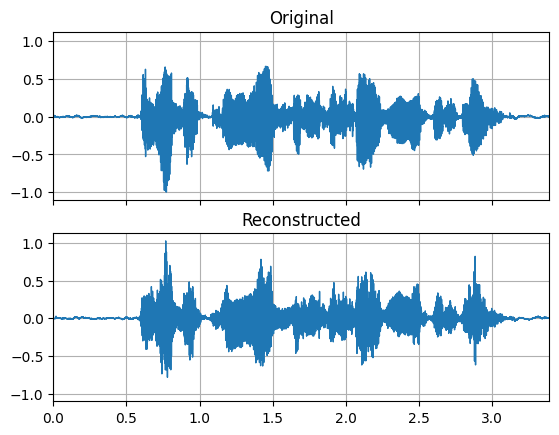

In [12]:
_, axes = plt.subplots(2, 1, sharex=True, sharey=True)
plot_waveform(SPEECH_WAVEFORM, SAMPLE_RATE, title="Original", ax=axes[0])
plot_waveform(reconstructed_waveform, SAMPLE_RATE, title="Reconstructed", ax=axes[1])
Audio(reconstructed_waveform, rate=SAMPLE_RATE)

## Mel Filter Bank

:py:func:`torchaudio.functional.melscale_fbanks` generates the filter bank
for converting frequency bins to mel-scale bins.

Since this function does not require input audio/features, there is no
equivalent transform in :py:func:`torchaudio.transforms`.




In [13]:
n_fft = 256
n_mels = 64
sample_rate = 6000

mel_filters = F.melscale_fbanks(
    int(n_fft // 2 + 1),
    n_mels=n_mels,
    f_min=0.0,
    f_max=sample_rate / 2.0,
    sample_rate=sample_rate,
    norm="slaney",
)

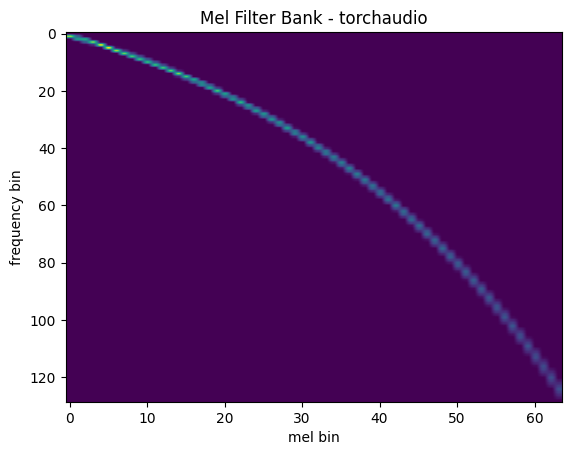

In [14]:
plot_fbank(mel_filters, "Mel Filter Bank - torchaudio")

### Comparison against librosa

For reference, here is the equivalent way to get the mel filter bank
with ``librosa``.




In [15]:
mel_filters_librosa = librosa.filters.mel(
    sr=sample_rate,
    n_fft=n_fft,
    n_mels=n_mels,
    fmin=0.0,
    fmax=sample_rate / 2.0,
    norm="slaney",
    htk=True,
).T

Mean Square Difference:  3.924735763781171e-17


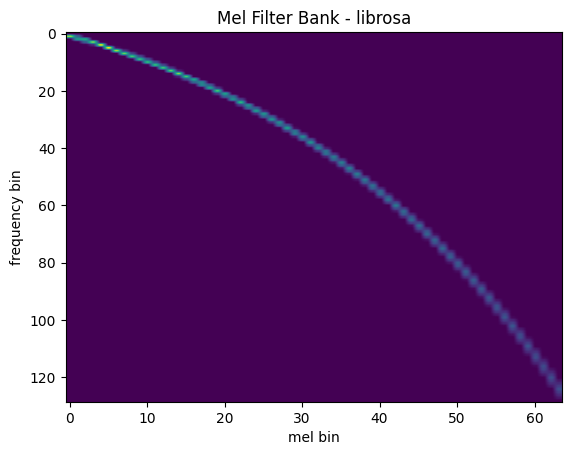

In [16]:
plot_fbank(mel_filters_librosa, "Mel Filter Bank - librosa")

mse = torch.square(mel_filters - mel_filters_librosa).mean().item()
print("Mean Square Difference: ", mse)

## MelSpectrogram

Generating a mel-scale spectrogram involves generating a spectrogram
and performing mel-scale conversion. In ``torchaudio``,
:py:func:`torchaudio.transforms.MelSpectrogram` provides
this functionality.




In [17]:
n_fft = 1024
win_length = None
hop_length = 512
n_mels = 128

mel_spectrogram = T.MelSpectrogram(
    sample_rate=sample_rate,
    n_fft=n_fft,
    win_length=win_length,
    hop_length=hop_length,
    center=True,
    pad_mode="reflect",
    power=2.0,
    norm="slaney",
    n_mels=n_mels,
    mel_scale="htk",
)

melspec = mel_spectrogram(SPEECH_WAVEFORM)

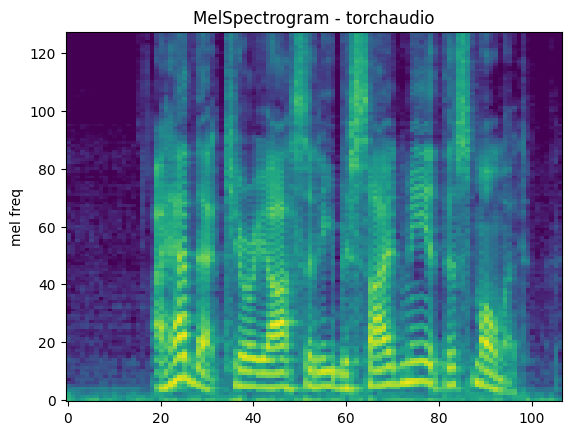

In [18]:
plot_spectrogram(melspec[0], title="MelSpectrogram - torchaudio", ylabel="mel freq")

### Comparison against librosa

For reference, here is the equivalent means of generating mel-scale
spectrograms with ``librosa``.




In [19]:
melspec_librosa = librosa.feature.melspectrogram(
    y=SPEECH_WAVEFORM.numpy()[0],
    sr=sample_rate,
    n_fft=n_fft,
    hop_length=hop_length,
    win_length=win_length,
    center=True,
    pad_mode="reflect",
    power=2.0,
    n_mels=n_mels,
    norm="slaney",
    htk=True,
)

Mean Square Difference:  1.291122653235277e-09


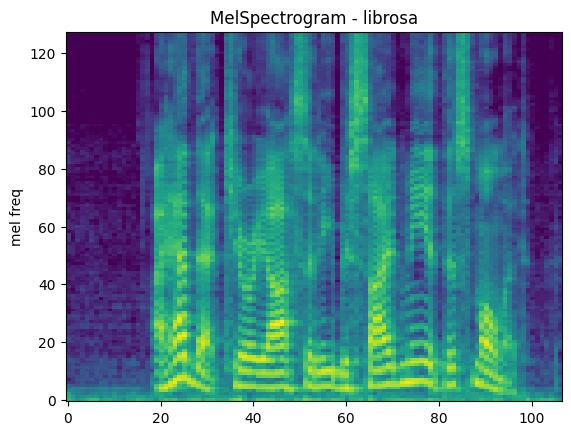

In [20]:
plot_spectrogram(melspec_librosa, title="MelSpectrogram - librosa", ylabel="mel freq")

mse = torch.square(melspec - melspec_librosa).mean().item()
print("Mean Square Difference: ", mse)

## MFCC




In [21]:
n_fft = 2048
win_length = None
hop_length = 512
n_mels = 256
n_mfcc = 256

mfcc_transform = T.MFCC(
    sample_rate=sample_rate,
    n_mfcc=n_mfcc,
    melkwargs={
        "n_fft": n_fft,
        "n_mels": n_mels,
        "hop_length": hop_length,
        "mel_scale": "htk",
    },
)

mfcc = mfcc_transform(SPEECH_WAVEFORM)

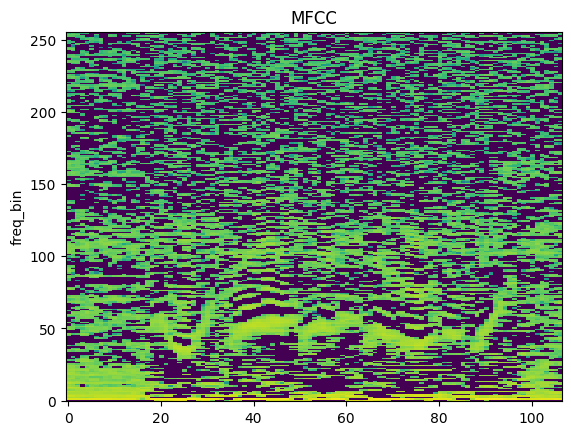

In [22]:
plot_spectrogram(mfcc[0], title="MFCC")

### Comparison against librosa




In [23]:
melspec = librosa.feature.melspectrogram(
    y=SPEECH_WAVEFORM.numpy()[0],
    sr=sample_rate,
    n_fft=n_fft,
    win_length=win_length,
    hop_length=hop_length,
    n_mels=n_mels,
    htk=True,
    norm=None,
)

mfcc_librosa = librosa.feature.mfcc(
    S=librosa.core.spectrum.power_to_db(melspec),
    n_mfcc=n_mfcc,
    dct_type=2,
    norm="ortho",
)

Mean Square Difference:  0.8103950023651123


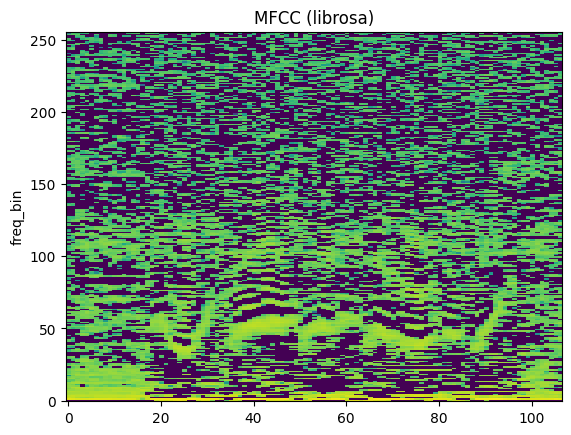

In [24]:
plot_spectrogram(mfcc_librosa, title="MFCC (librosa)")

mse = torch.square(mfcc - mfcc_librosa).mean().item()
print("Mean Square Difference: ", mse)

## LFCC




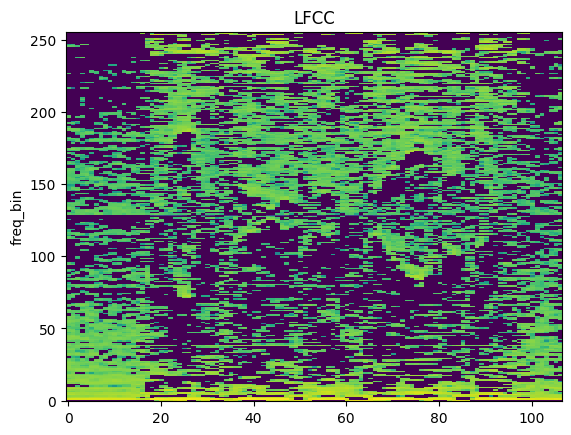

In [25]:
n_fft = 2048
win_length = None
hop_length = 512
n_lfcc = 256

lfcc_transform = T.LFCC(
    sample_rate=sample_rate,
    n_lfcc=n_lfcc,
    speckwargs={
        "n_fft": n_fft,
        "win_length": win_length,
        "hop_length": hop_length,
    },
)

lfcc = lfcc_transform(SPEECH_WAVEFORM)
plot_spectrogram(lfcc[0], title="LFCC")

## Pitch




In [26]:
pitch = F.detect_pitch_frequency(SPEECH_WAVEFORM, SAMPLE_RATE)

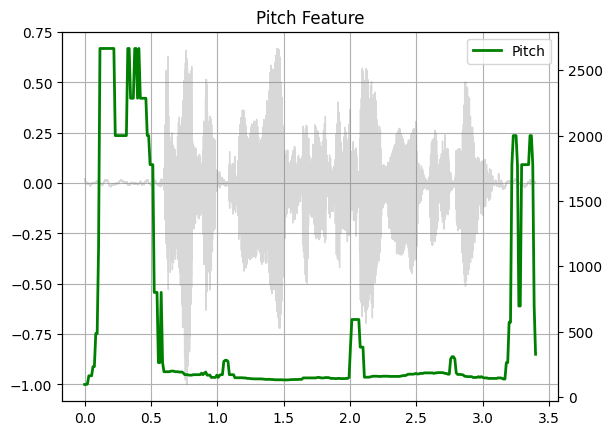

In [27]:
def plot_pitch(waveform, sr, pitch):
    figure, axis = plt.subplots(1, 1)
    axis.set_title("Pitch Feature")
    axis.grid(True)

    end_time = waveform.shape[1] / sr
    time_axis = torch.linspace(0, end_time, waveform.shape[1])
    axis.plot(time_axis, waveform[0], linewidth=1, color="gray", alpha=0.3)

    axis2 = axis.twinx()
    time_axis = torch.linspace(0, end_time, pitch.shape[1])
    axis2.plot(time_axis, pitch[0], linewidth=2, label="Pitch", color="green")

    axis2.legend(loc=0)


plot_pitch(SPEECH_WAVEFORM, SAMPLE_RATE, pitch)